# Notebook used for the making of the single atom SET (first attempt).
#### It includes scan stitching, dopant finding, etc

In [1]:
import sys
from pathlib import Path
# Add the parent directory to sys.path so we can import NVM and ASD from parent directory
sys.path.append(str(Path().resolve().parent.parent))
import NavigatingTheMatrix as nvm
import As_detection as asd

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import cv2
import importlib 
import re

Currently, the scan stitching requires some spatial information to be given. It requires the relative position of the scans to each other i.e. we assume a 2D array of scans of shape n x n. Then the scans need a label (i, j) to indicate where in the array they are.
I'm unsure of the most efficient/easiest way to implement this. If scanning is done automatically and each following scan has a definite and known relationship with the previous, it's relatively easy to get this (i, j) labelling. This likely won't be the case most of the time though. ATM I think the easiest will be if the desired scans are moved into a separate folder and just this folder is processed so it's easy enough to ignore the scans inbetween where tip cleaning etc is performed.

NOTE: for Westbourne Park the tip wasn't good enough to collect several scans in a row and perform the full pattern finding procedure. There is only one scan. I've gone through the full workflow below anyway to illustrate how it'd work nonetheless.

In [2]:
# make a dictionary of the scans you want to stitch

scans = {}

dir_path = Path().resolve()

# get list of all scan numbers from the filenames in the directory
scan_numbers = []
for filename in os.listdir(dir_path):
    if filename[-6:] == 'Z_mtrx':
        match = re.search(r'--(\d+)_', filename)
        if match:
            scan_number = int(match.group(1))
            scan_numbers.append(scan_number)

# scans are arranged in a raster pattern. Smallest scan number is bottom left, from there it goes right 3, then up 1, left 3, up 1, etc.

scan_numbers.sort()
print('Scan numbers found:', scan_numbers)

n = 0 # counter to keep track of the scan number in the raster pattern
for scan_number in scan_numbers:
    for filename in os.listdir(dir_path):
        if filename[-6:] == 'Z_mtrx':
            match = re.search(r'--(\d+)_', filename)
            if match:
                number = int(match.group(1))
            if scan_number == number:
                n1 = n//3
                n2 = n%3
                scan_dict = {'file': os.path.join(dir_path, filename), 
                            'standard_pix_ratio': 512/100
                            }
                scans[(n1,n2)] = nvm.STM(scan_dict)
                n += 1 
                

Scan numbers found: [15]
Pixel to nm ratio is 23pixels for every 100nm in the  trace down
trace down scan was interupted before completion. It will not be used.
Pixel to nm ratio is 23pixels for every 100nm in the  retrace down
retrace down scan was interupted before completion. It will not be used.


In [3]:
# tidy up the scans. 

for scan in scans.values():
    scan.clean_up(scan.trace_up, 'trace up', plane_level=True)
    scan.clean_up(scan.retrace_up, 'retrace up', plane_level=True)

In [4]:
# correct hysterisis in the scans

for scan in scans.values():
    scan.trace_up_proc, scan.retrace_up_proc, corrected, k3_1 = scan.correct_hysteresis(scan.trace_up_proc, scan.retrace_up_proc, 'trace up')

Number of matches found for hysteresis correction: 55 . If it's only a few (less than ~3) the correction will not be very accurate.


(512, 512)


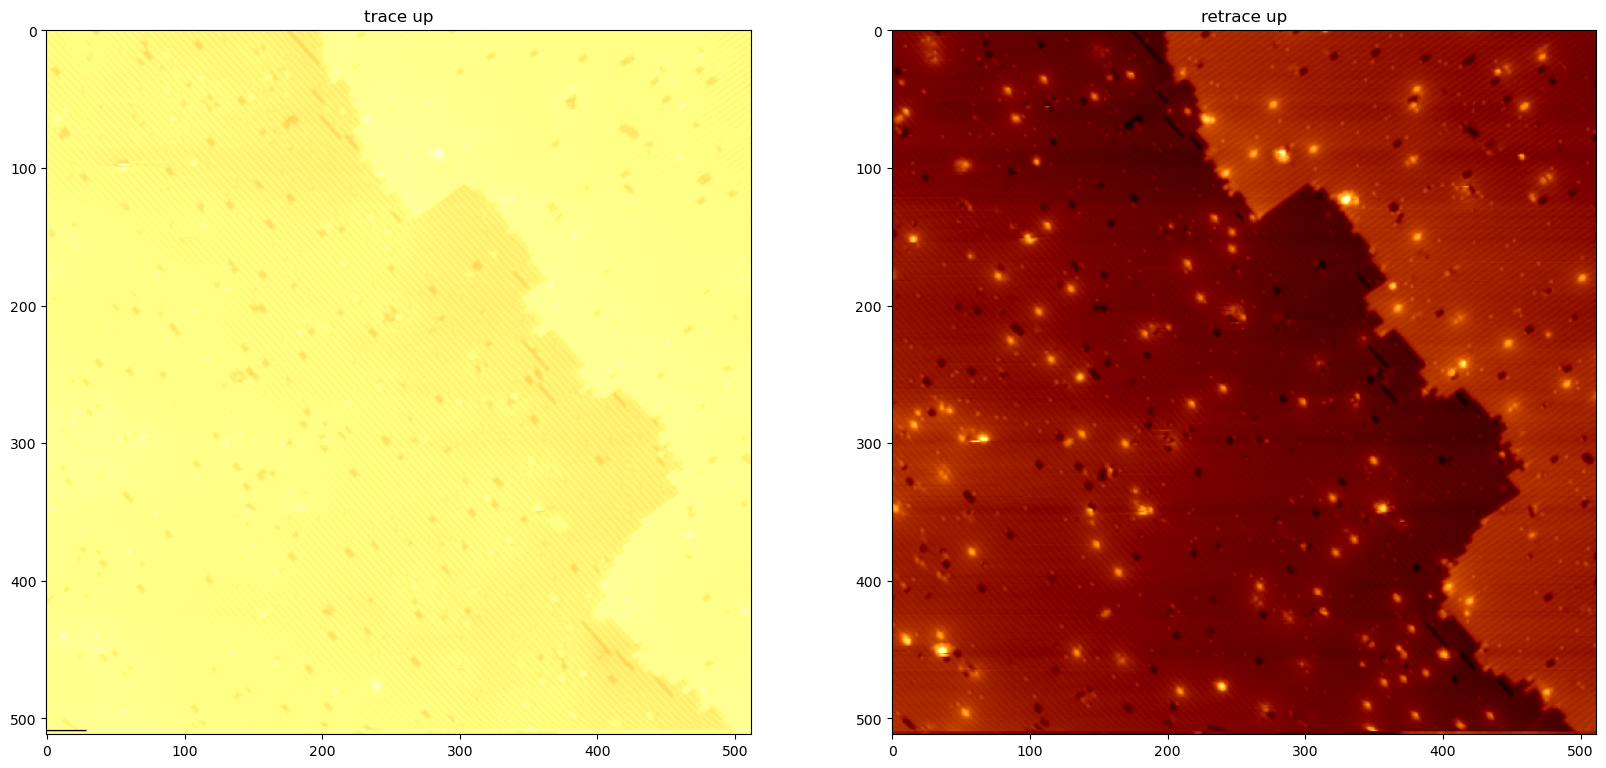

In [5]:
# plot a few to check they are as expetected.
# Note that many of the scans uses in this example are of bad quality.

for i, key in enumerate(scans.keys()):
        print(scans[key].trace_up_proc.shape)
        fig, ax = plt.subplots(1,2, figsize=(20,15))
        ax[0].imshow(scans[key].trace_up_proc, cmap='afmhot')
        ax[0].set_title('trace up')
        ax[1].imshow(scans[key].retrace_up_proc, cmap='afmhot')
        ax[1].set_title('retrace up')
        plt.show()

Can't see the image well because the scan was moved right at the start so it's ruined the colour scale. To fix it just make the bottom few lines=0.5

In [6]:
for i, key in enumerate(scans.keys()):
    scans[key].trace_up_proc[509:,:] = 0.5

(512, 512)


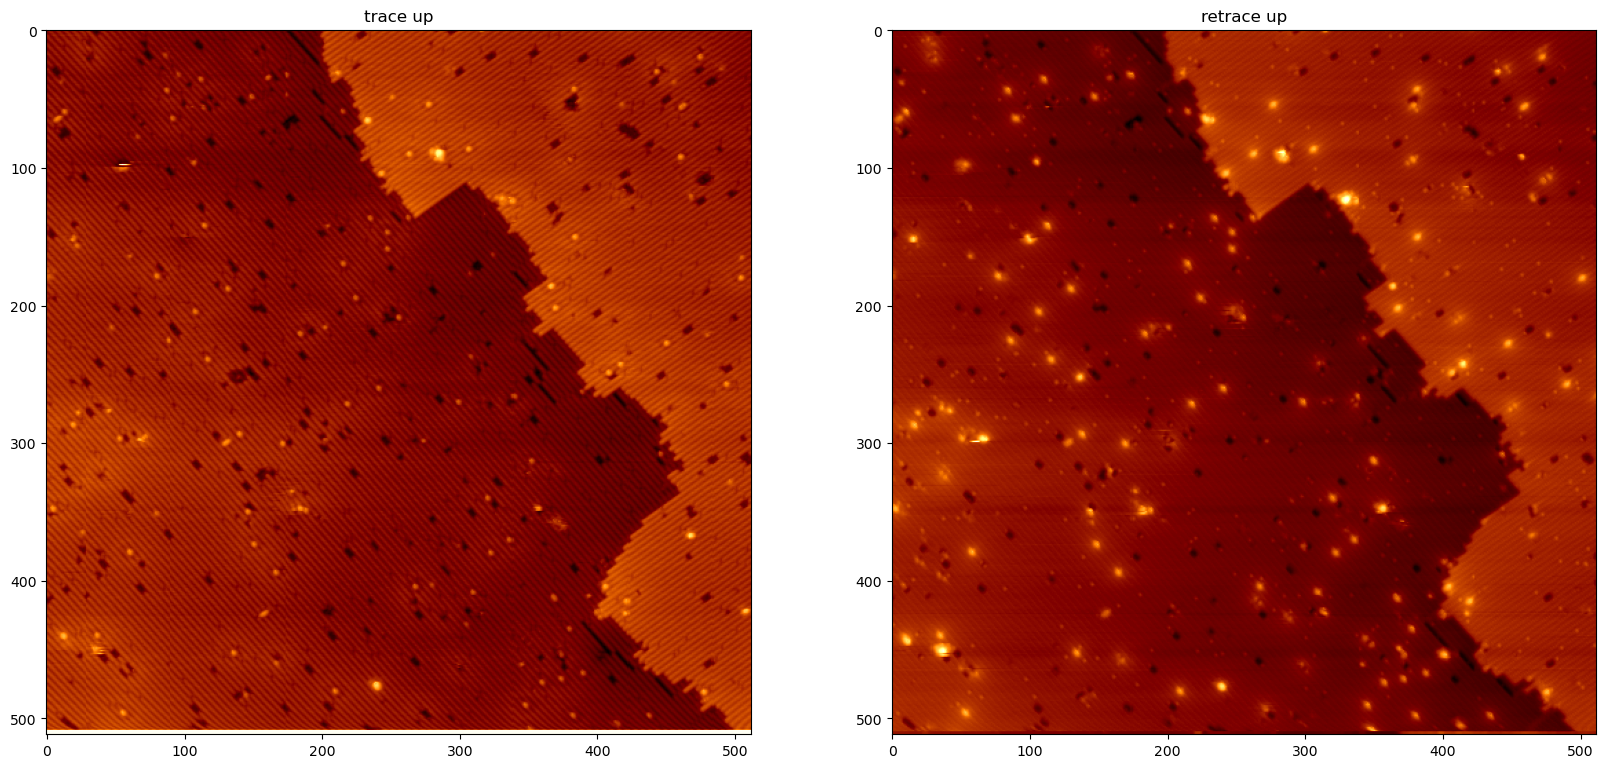

In [7]:
for i, key in enumerate(scans.keys()):
        print(scans[key].trace_up_proc.shape)
        fig, ax = plt.subplots(1,2, figsize=(20,15))
        ax[0].imshow(scans[key].trace_up_proc, cmap='afmhot')
        ax[0].set_title('trace up')
        ax[1].imshow(scans[key].retrace_up_proc, cmap='afmhot')
        ax[1].set_title('retrace up')
        plt.show()

In [21]:
importlib.reload(asd)

<module 'As_detection' from 'C:\\Users\\Matrix\\Documents\\github\\NavigatingTheMatrix\\As_detection.py'>

In [22]:
# create detector object. This is used to segment the scans and find features.
detector = asd.Detector()

In [23]:
# make a dict of the scans to use
segmented_scans = {}

for key, scan in scans.items():
    print(key)
    segmented_scans[key] = asd.Si_Scan(scan, 'trace up', As=True)
    segmented_scans[key].one_hot_segmented = detector.predict(segmented_scans[key])
    segmented_scans[key].rgb = detector.turn_rgb(segmented_scans[key].one_hot_segmented)

(0, 0)
Resolution of image is 512 by 512
Number of features is 134


In [24]:
for i, (key,scan) in enumerate(scans.items()):
    print(segmented_scans[key].feature_coords['anomalies'])

[array([ 21, 475], dtype=int64), array([ 29, 491], dtype=int64), array([33, 96], dtype=int64), array([ 32, 212], dtype=int64), array([ 35, 161], dtype=int64), array([ 33, 175], dtype=int64), array([ 36, 113], dtype=int64), array([ 43, 384], dtype=int64), array([ 49, 149], dtype=int64), array([ 48, 175], dtype=int64), array([ 55, 278], dtype=int64), array([ 57, 461], dtype=int64), array([ 58, 115], dtype=int64), array([66,  8], dtype=int64), array([65, 92], dtype=int64), array([ 66, 234], dtype=int64), array([ 87, 307], dtype=int64), array([ 90, 286], dtype=int64), array([ 90, 264], dtype=int64), array([ 90, 281], dtype=int64), array([99, 56], dtype=int64), array([124, 331], dtype=int64), array([125, 338], dtype=int64), array([135, 319], dtype=int64), array([143, 205], dtype=int64), array([148, 248], dtype=int64), array([151, 384], dtype=int64), array([153,  20], dtype=int64), array([153,  20], dtype=int64), array([165,  62], dtype=int64), array([203, 370], dtype=int64), array([226,  90

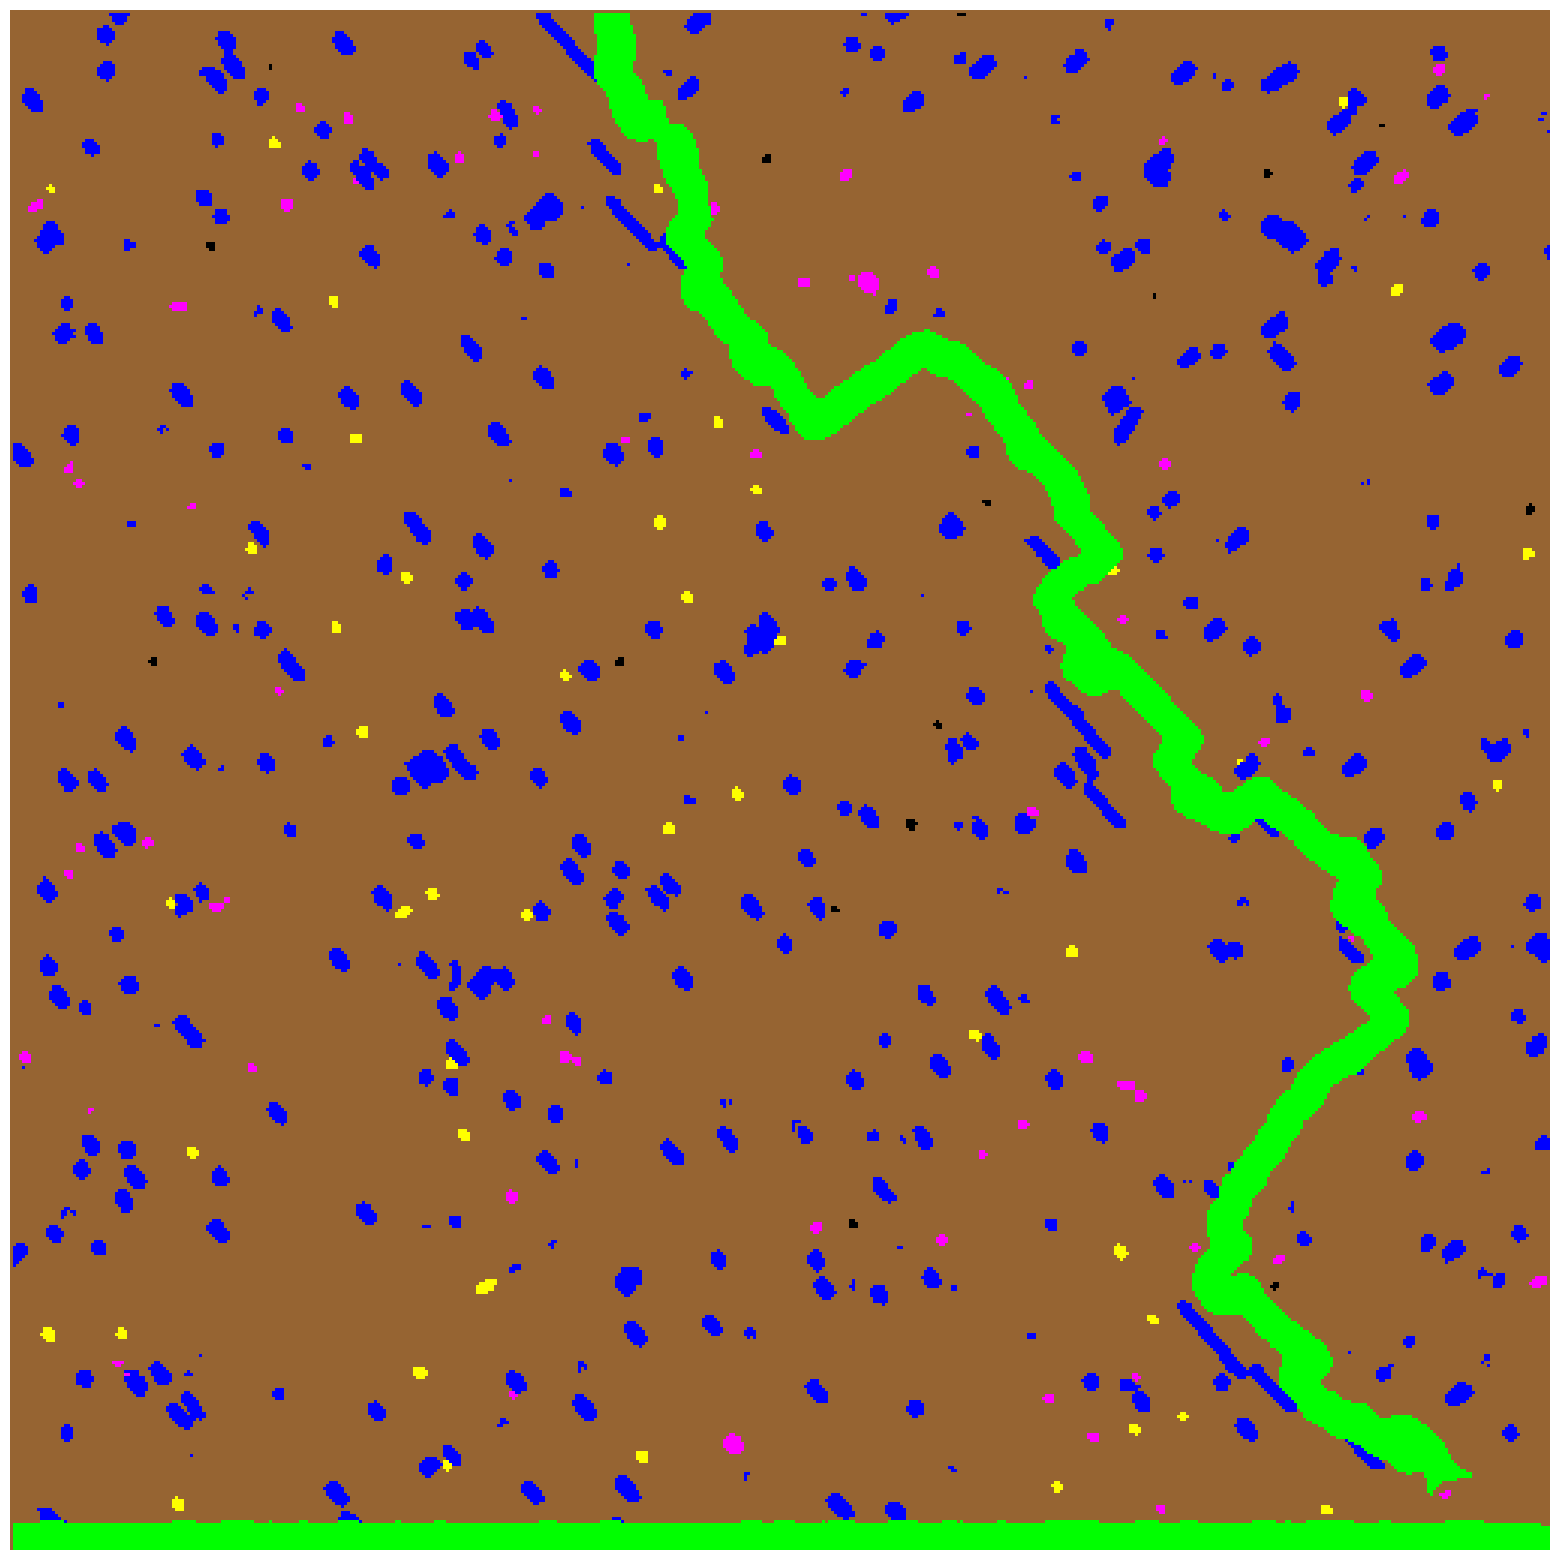

In [25]:
for i, (key,scan) in enumerate(scans.items()):
    plt.figure(figsize=(20, 20))
    plt.imshow(segmented_scans[key].rgb)
    plt.axis('off')
    plt.show()

### Find the homographies between all neigHbours. We do one with a size_change_thresh of 0.001 and one with 0.05.
#### There are no neighbours here but I'll leave this here in case it's useful to look at

In [26]:
ScanStitcher = asd.segmented_scan_stitcher()

In [27]:
# get the homographies between neighbours where possible
homographies, graph, homographies_type, keypoints = ScanStitcher.get_all_homographies(segmented_scans, round_to = 10, counts1=4, counts2=10,show_plot=True, size_change_thresh=0.0001)

# graph is a dictionary which outlines the valid connections found between the scans.

Currently working on:  (1, 0) (0, 0)
Currently working on:  (0, 1) (0, 0)


In [28]:
# this function stitches the scans by using homographies that were calculated by 
# comparing one scan with its neighbours
stitched_scan = ScanStitcher.stitch_from_homographies(segmented_scans, homographies, graph, stitch_for_n=6)

In [29]:
def turn_rgb(self, array, scan = False):
    '''
    Turns one-hot encoded array with up to 7 categories into an rgb image

    Args:
        array (ndarray): shape (res,res,7) with the different features labelled with
                one-hot encoding.
    returns:
        output (ndarray): Shape (res,res,3) with the different features labelled with
                rgb encoding.
        legend (dict): The rgb values as keys and the corresponding feature as values
        scan (False or ndarray): If not false, the scan is used to make the output have zeros where the scan is zero
    '''
    # Define the mapping from categories to RGB colors
    category_to_rgb = (255*np.array(list(self.legend.keys()))).astype(np.uint8)

    # Get the category indices from the one-hot encoded array
    category_indices = np.argmax(array, axis=-1)

    # Map the category indices to RGB colors
    output = category_to_rgb[category_indices]

    if np.any(scan) != False:
        # if given the true scan, we want to have zeros in the same places.
        output[scan[:,:,0]==0] = [0,0,0]

    return output

In [30]:
# object returned is a Si_scan object and all defects are transformed to the new coordinates sytem 
# + we get a new one hot segmented maps but we don't have a rgb image of the new scan
stitched_scan.rgb = turn_rgb(detector, stitched_scan.one_hot_segmented, stitched_scan.scan)

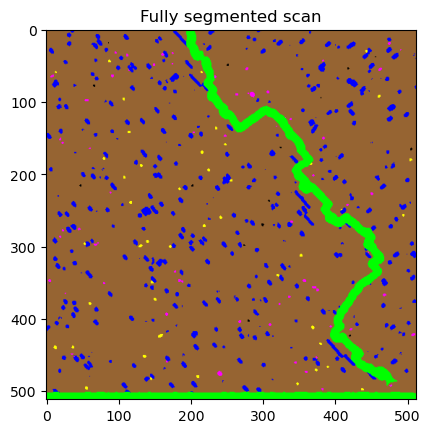

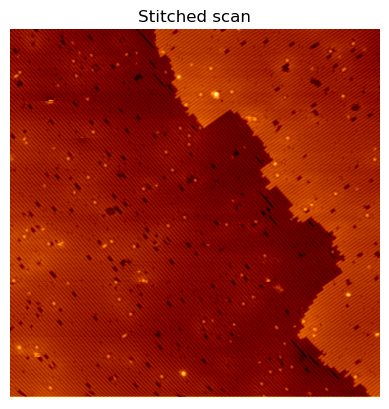

In [31]:
axis_ticks = np.linspace(0, stitched_scan.scan.shape[1], 2)
axis_labels = axis_ticks/512*1000
plt.imshow(stitched_scan.rgb)
#plt.xticks(axis_ticks, axis_labels)
plt.title('Fully segmented scan')
plt.show()

plt.imshow(stitched_scan.scan[:,:,0], cmap='afmhot')
plt.title('Stitched scan')
plt.axis('off')
plt.show()

### Now we can also find pairs and triplet in this scan.

In [32]:
# first find distances between all features

stitched_scan.feature_dists()

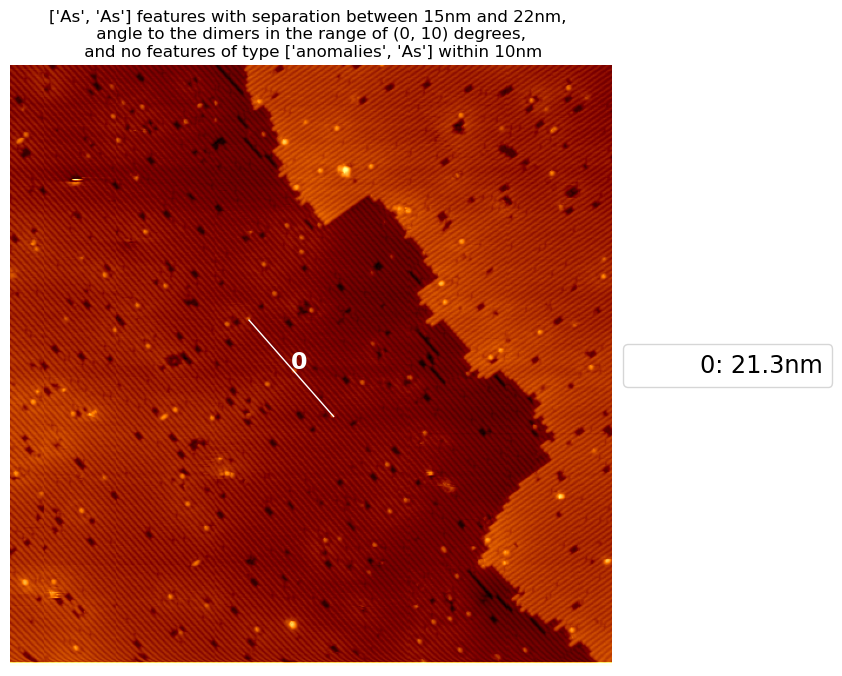

In [33]:
# find 'oneDB' pairs at a distance of between 10 nm and 8 nm, that also have no other 'oneDB' defects within 10 nm.

As_pairs = stitched_scan.find_pairs('As', 'As', max_dist=22, min_dist=15, angle=(0,10),
                                        exclusion_dist = 10,  display_image=True,exclusion_defects = ['anomalies', 'As'])